In [1]:
!wget https://bit.ly/fruits_300_data -O fruits_300.npy

--2025-02-25 13:21:58--  https://bit.ly/fruits_300_data
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rickiepark/hg-mldl/raw/master/fruits_300.npy [following]
--2025-02-25 13:21:58--  https://github.com/rickiepark/hg-mldl/raw/master/fruits_300.npy
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/hg-mldl/master/fruits_300.npy [following]
--2025-02-25 13:21:58--  https://raw.githubusercontent.com/rickiepark/hg-mldl/master/fruits_300.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... conne

In [2]:
import numpy as np
from sklearn.decomposition import PCA

fruits = np.load('fruits_300.npy')
fruits_2d = fruits.reshape(-1, 100*100)

pca = PCA(n_components=50)      # 주성분 분석
pca.fit(fruits_2d)

print(pca.components_.shape)    # 주성분 개수, 원본 데이터의 특성 개수

(50, 10000)


In [3]:
import matplotlib.pyplot as plt

def draw_fruits(arr, ratio=1):
    n = len(arr)    # n은 샘플 개수입니다

    # 한 줄에 10개씩 이미지를 그립니다. 샘플 개수를 10으로 나누어 전체 행 개수를 계산합니다.
    rows = int(np.ceil(n/10))
    # 행이 1개 이면 열 개수는 샘플 개수입니다. 그렇지 않으면 10개입니다.
    cols = n if rows < 2 else 10

    fig, axs = plt.subplots(rows, cols, figsize=(cols*ratio, rows*ratio), squeeze=False)

    for i in range(rows):
        for j in range(cols):
            if i*10 + j < n:    # n 개까지만 그립니다.
                axs[i, j].imshow(arr[i*10 + j], cmap='gray_r')
            axs[i, j].axis('off')
    plt.show()

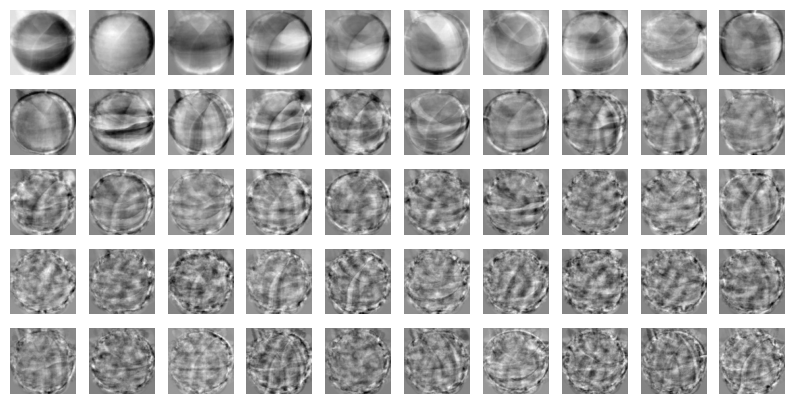

In [4]:
draw_fruits(pca.components_.reshape(-1, 100, 100))

In [5]:
print(fruits_2d.shape)

fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)     # 차원 축소

(300, 10000)
(300, 50)


In [6]:
fruits_inverse = pca.inverse_transform(fruits_pca)
print(fruits_inverse.shape)     # 원본 데이터 재구성

(300, 10000)


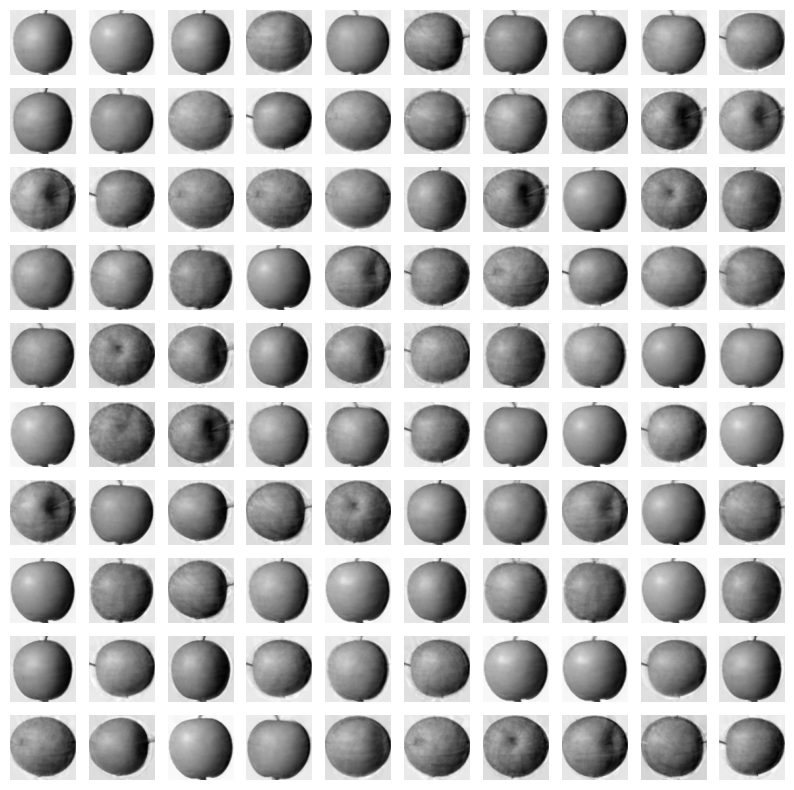

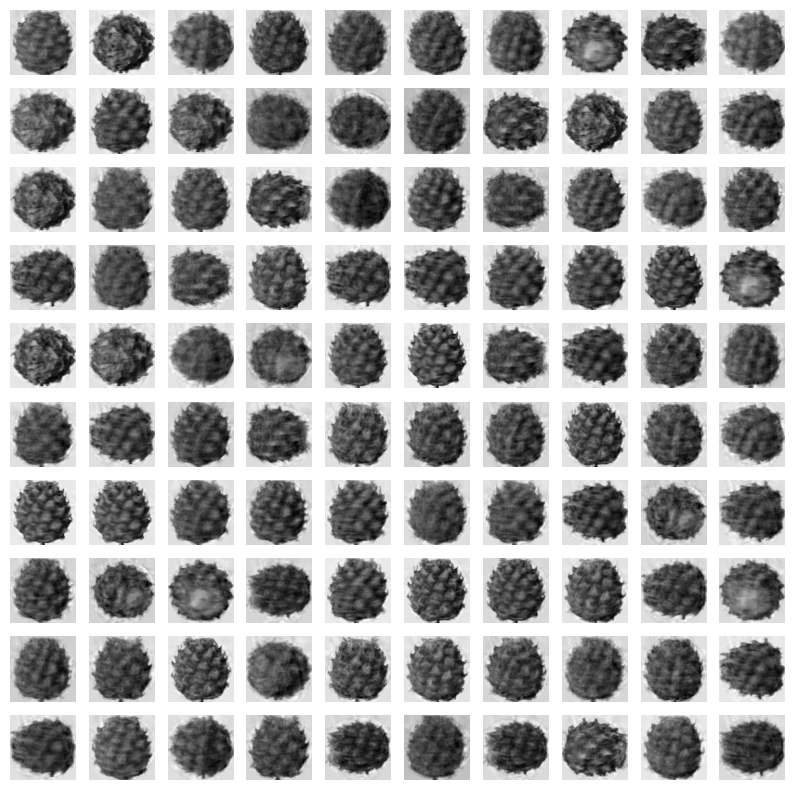

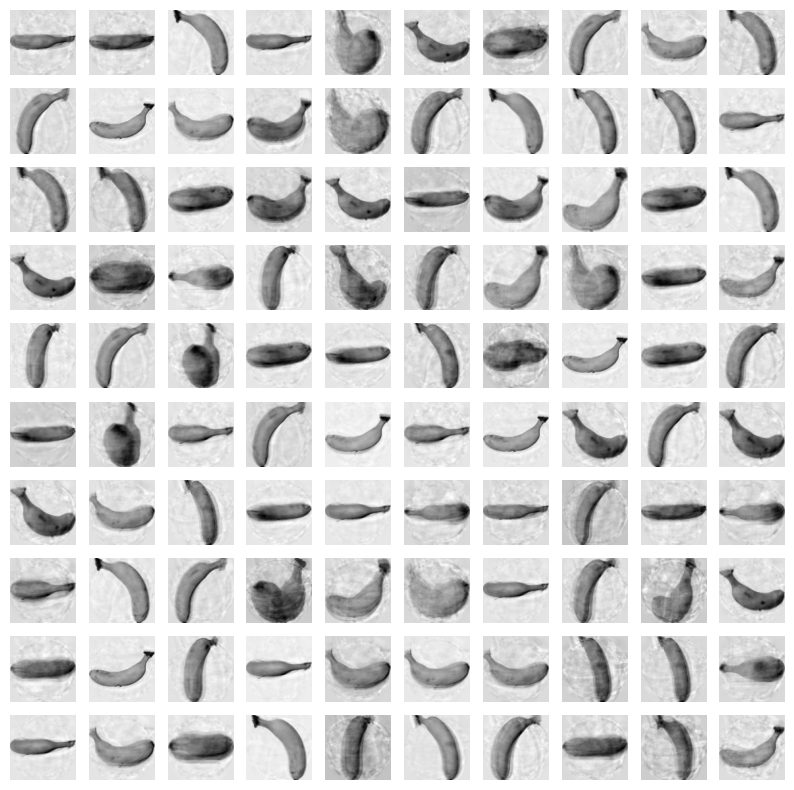

In [7]:
fruits_reconstruct = fruits_inverse.reshape(-1, 100, 100)

for start in [0, 100, 200]:
    draw_fruits(fruits_reconstruct[start:start+100])
    print("\n")

In [8]:
print(np.sum(pca.explained_variance_ratio_))    # 설명된 분산

0.9215564026723061


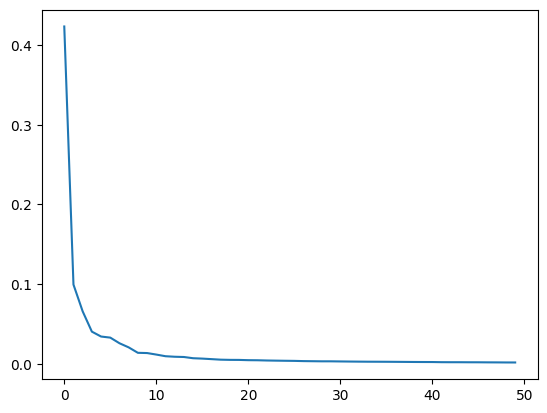

In [9]:
plt.plot(pca.explained_variance_ratio_)     # 첫 번째 주성분이 설명된 분산이 가장 큼

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

lr = LogisticRegression()   # 로지스틱 회귀 모델

target = np.array([0] * 100 + [1] * 100 + [2] * 100)

scores = cross_validate(lr, fruits_2d, target)  # 10000개의 특성을 가진 샘플로 교차 검증
print(np.mean(scores['test_score']))    # 과대적합
print(np.mean(scores['fit_time']))

0.9966666666666667
1.3933252811431884


In [11]:
scores = cross_validate(lr, fruits_pca, target)     # 50개의 특성을 가진 샘플(차원 축소)로 교차 검증
print(np.mean(scores['test_score']))    # 정확도 증가
print(np.mean(scores['fit_time']))      # 훈련 속도 증가

0.9966666666666667
0.010887670516967773


In [12]:
pca = PCA(n_components=0.5)     # 설명된 분산의 50%에 해당하는 주성분 찾기
pca.fit(fruits_2d)

print(pca.n_components_)    # 주성분 개수

2


In [13]:
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)     # 차원 축소

(300, 2)


In [14]:
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9933333333333334
0.04389133453369141


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [15]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=42)  # k-평균 알고리즘
km.fit(fruits_pca)

print(np.unique(km.labels_, return_counts=True))    # 레이블 별 샘플 개수

(array([0, 1, 2], dtype=int32), array([110,  99,  91]))


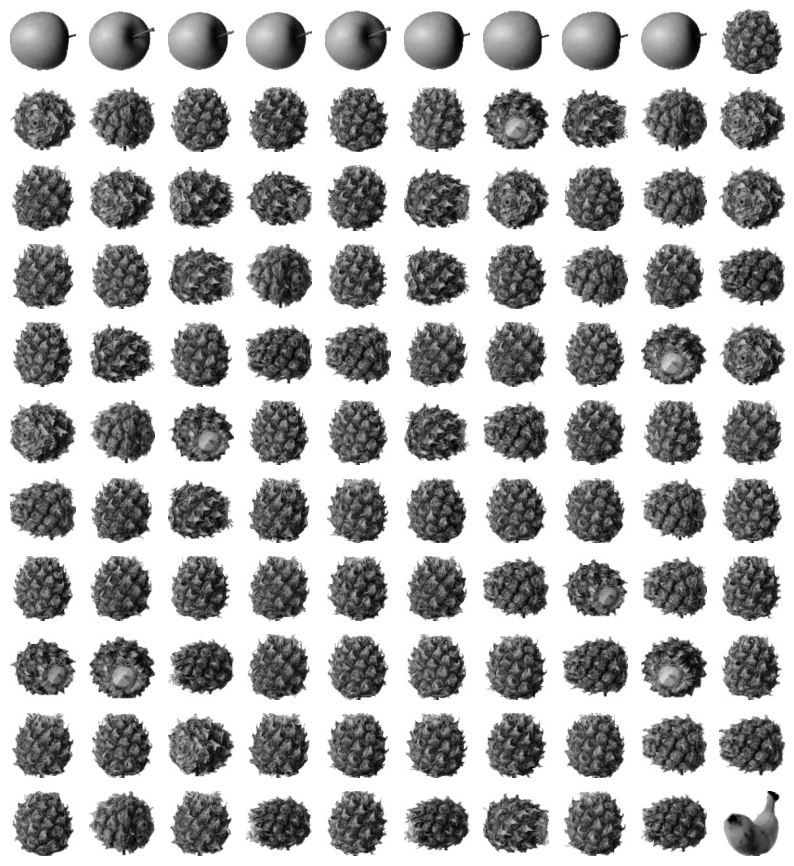

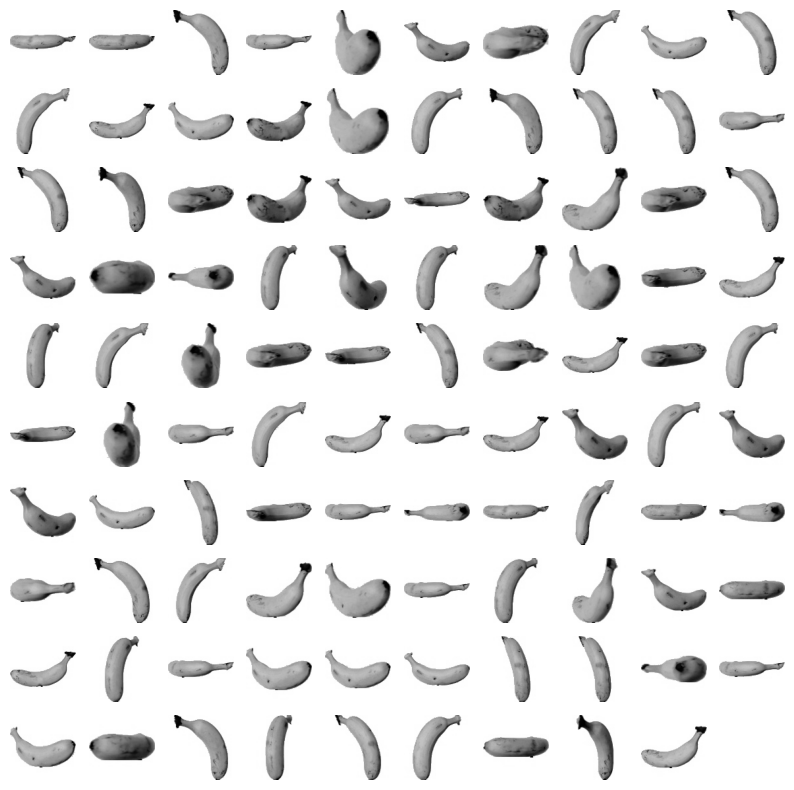

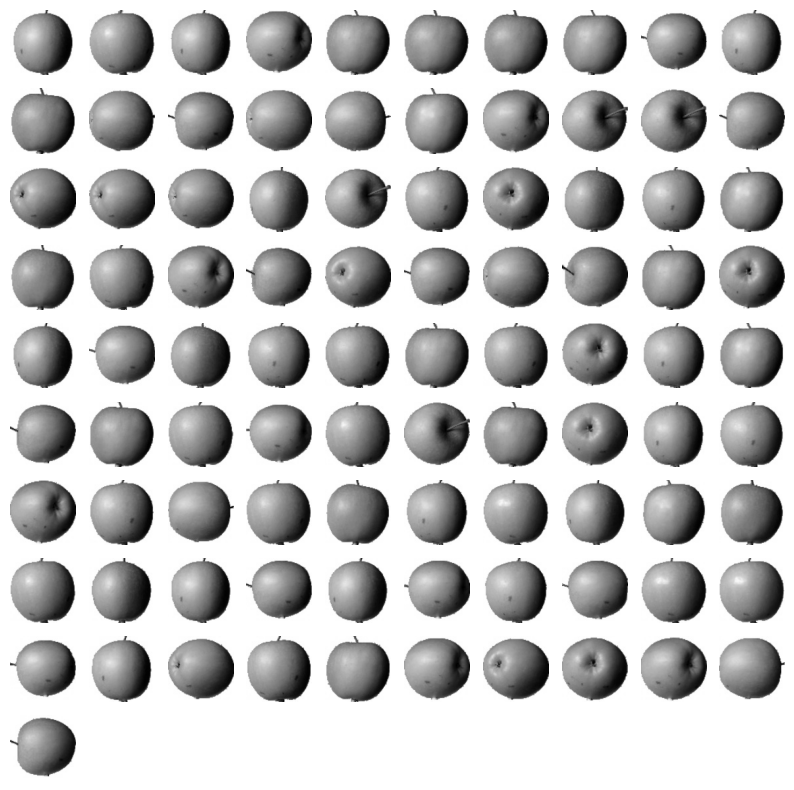

In [16]:
for label in range(0, 3):
    draw_fruits(fruits[km.labels_ == label])
    print("\n")

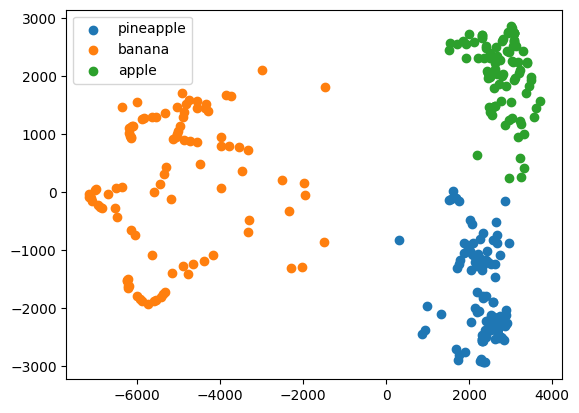

In [17]:
for label in range(0, 3):
    data = fruits_pca[km.labels_ == label]
    plt.scatter(data[:,0], data[:,1])
plt.legend(['pineapple', 'banana', 'apple'])
plt.show()